# Problem Set 3, due May 2 at 11:59am (i.e., noon).

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

*Also note:* For this assignment we are requiring you to use base **matplotlib** - not Seaborn or other packages. This will help you become familiar with techniques for maintaining fine-grained control over your data visualizations. It will also help our graders, who spent countless hours trying to make various versions import for grading.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [17]:
from sklearn.datasets import load_boston
bdata = load_boston()

boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]

median = pd.DataFrame(bdata.target)
median.columns = ['MEDV']

boston = pd.concat([boston, median], axis=1)

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

(array([  21.,   55.,   82.,  154.,   84.,   41.,   30.,    8.,   10.,   21.]),
 array([  5. ,   9.5,  14. ,  18.5,  23. ,  27.5,  32. ,  36.5,  41. ,
         45.5,  50. ]),
 <a list of 10 Patch objects>)

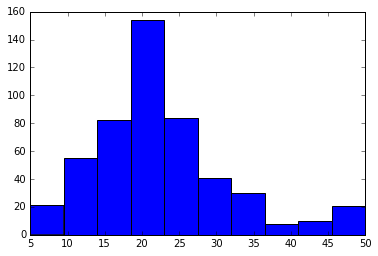

In [3]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  

# edit the code below to make the graph look good
plt.hist(bdata.target)

### 1.1: Scatter plot of housing prices and crime

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional. No excuses if you don't get it right this time around!


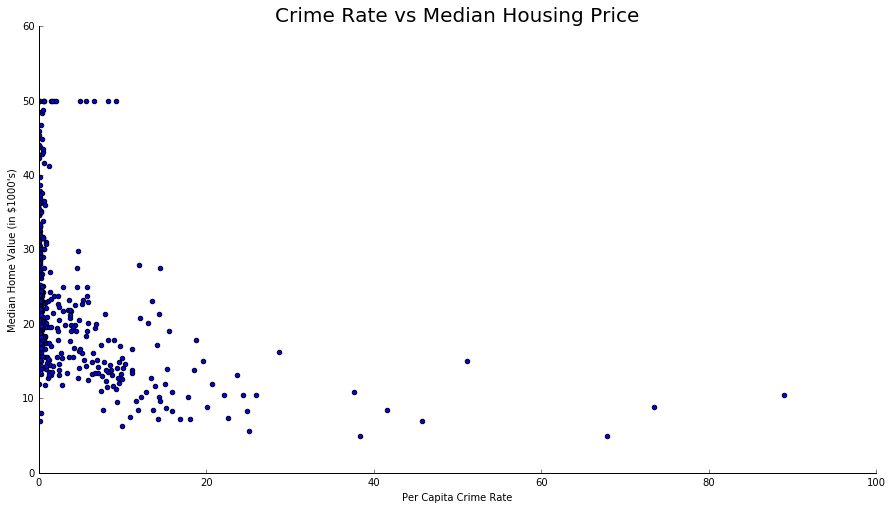

In [4]:
plt.scatter(boston.CRIM, boston.MEDV)

# make the labels and axes
plt.gcf().set_size_inches(15,8)
plt.xlabel('Per Capita Crime Rate')
plt.ylabel('Median Home Value (in $1000\'s)')
plt.xlim(0)
plt.title('Crime Rate vs Median Housing Price', fontsize=20)

# get rid of lines we don't want
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', top='off')     
plt.tick_params(axis='y', right='off')

#plt.axis([-2, 100, 0, 55])

plt.show()

### 1.2 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation)



In [5]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.16
actually 2.08166
"""
def compute_rmse(predictions, yvalues):
    rmse = 0
    for i in range(0, len(predictions)):
        predictions[i] = float(predictions[i])
        yvalues[i] = float(yvalues[i])
        
        rmse += (predictions[i] - yvalues[i]) * (predictions[i] - yvalues[i])
        
    rmse = rmse / len(predictions)
    rmse = np.sqrt(rmse)
    return rmse
    
print compute_rmse([2.0,2.0,3.0], np.array([0,2,6]))

2.08166599947


### 1.3 Divide your data into training and testing datasets

Randomly select 66% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 34% in a testing dataset (call this "bdata_test")


In [6]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

splitBoston = boston.copy()
splitBoston['Rand'] = splitBoston.apply(lambda row: np.random.random(), axis=1)

bdata_test = splitBoston[splitBoston.Rand < .34]
bdata_train = splitBoston[splitBoston.Rand >= .34]

### 1.4 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Compute the RMSE on the training set.  Now compute the RMSE on the test data set (but use the model you trained on the training set!).  How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?

In [7]:
train_rmse = compute_rmse(np.full(bdata_train.shape[0], bdata_train.MEDV.mean()), bdata_train.MEDV.values)
test_rmse = compute_rmse(np.full(bdata_test.shape[0], bdata_train.MEDV.mean()), bdata_test.MEDV.values)

print train_rmse
print test_rmse

9.86652442397
7.80448304428


The RMSE on the training set is larger than that of the test set. This implies the "model" (just the mean) of the training data is a more accurate prediction of the test data than it is of the training data where it came from.

This is not what I expected, I expected the mean to be more predictave of the data it came from than the other set if they were not the same (which I would have expected because the groups were randomly assigned).

I can only guess as to why exactly this happened. It could be because the training set is larger there were more chances for outliers which have a greater effect on the RMSE, though really because it was random each group should have the same proportion of outliers.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm](http://en.wikipedia.org/wiki/Norm_(mathematics) distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).

In [8]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    dist = 0;
    for i in range(0, len(x1)):
        dist += abs(float(x1[i]) - float(x2[i])) ** L
    
    dist **= (1.0/L)
    return dist

print distance((3,4), (6,8), 1)

7.0


### 2.2 Basic Nearest Neighbor algorithm

Now things get fun.  Your task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts, for each instance in the testing data (bdata_test), the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Compute the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.  Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.

In [9]:
"""
Function
--------
nneighbor

Given two datasets (train and test), a list of features to compare, a target feature to predict, and L
compute the rmse of the predictions generated on this model

Parameters
----------
train, test : pd DataFrame
    "train" data frame and "test" data frame

features
    features to predict on
    
target
    feature to predict for

L: int
    Value of L to use in computing distances

Returns
-------
rmse : float
    the rmse of the predictions
"""
import time
def nneighbor(train, test, features, target, L):
    start_time = time.time()
    
    predictions = np.empty(len(test[target].values))
    
    # loop over test data (heck each test data point against train set)
    for i in range(0, len(test[target].values)):
        closestDistance = 999999
        closestIndex = -1
        
        # go through the train set
        for j in range(0, len(train[target].values)):
            x1 = []
            x2 = []
            
            # go through the features
            for k in range(0, len(features)):
                x1.append(test[features[k]].values[i])
                x2.append(train[features[k]].values[j])
                
            thisDistance = distance(x1, x2, L)
            
            if(thisDistance < closestDistance):
                closestDistance = thisDistance
                closestIndex = j
        
        # get the closest value
        predictions[i] = (train[target].values[closestIndex])
        
    rmse = compute_rmse(predictions, test[target].values)

    print "nneighbor time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return rmse

print nneighbor(bdata_train, bdata_test, ['CRIM', 'RM'], 'MEDV', 2)

nneighbor time taken: 0.88 seconds
7.33234714172


### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [10]:
"""
Function
--------
normalize

Given an array returns the normalized array

Parameters
----------
raw_data : array
    data to normalize
    
Returns
-------
normalized_data : array
    normalized data
"""
def normalize(raw_data):
    raw_data = np.array(raw_data)
    dataStd = raw_data.std()
    dataMean = raw_data.mean()
    normalized_data = []
    
    for i in range(0, len(raw_data)):
        normalized_data.append((raw_data[i] - dataMean) / dataStd)
    
    return normalized_data

"""
Function
--------
normalize_dataframe

Given a dataframe and set of features to normalize returns the normalized dataframe

Parameters
----------
dataframe : pd.DataFrame
    dataframe to normalize

features: array
    features in the dataframe to normalize
    
Returns
-------
normalized : pd.DataFrame
    normalized dataframe
"""
def normalize_dataframe(dataframe, features):
    normalized = dataframe.copy()
    for feature in features:
        normalized[feature] = normalize(dataframe[feature].values)
        
    return normalized

featuresToNorm = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

normalized_bdata_train = normalize_dataframe(bdata_train, featuresToNorm)
normalized_bdata_test = normalize_dataframe(bdata_test, featuresToNorm)
 
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['CRIM', 'RM'], 'MEDV', 2)

nneighbor time taken: 0.92 seconds
8.22264275842


the RMSE went from 7.33 to 8.22 after normalization.

This implies that normalization lowered the influene of one or more of the more accurate predictors, or increased the influence of less accurate ones, by making every feature equivilantly weighted.

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

In [11]:
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['AGE', 'TAX'], 'MEDV', 2)
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['AGE', 'TAX','CRIM', 'RM'], 'MEDV', 2)
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['AGE', 'TAX'], 'MEDV', 3)
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['AGE', 'TAX','CRIM', 'RM'], 'MEDV', 3)
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['AGE', 'TAX'], 'MEDV', 1)
print nneighbor(normalized_bdata_train, normalized_bdata_test, ['AGE', 'TAX','CRIM', 'RM'], 'MEDV', 1)

nneighbor time taken: 0.91 seconds
10.8549087948
nneighbor time taken: 1.86 seconds
7.64072839048
nneighbor time taken: 0.89 seconds
10.8458944752
nneighbor time taken: 1.6 seconds
7.62094983611
nneighbor time taken: 0.85 seconds
10.8274022946
nneighbor time taken: 1.77 seconds
7.08537423781


I had the most accuracy with an L of 1 and 4 features AGE TAX CRIM and RM.

Increasing the number of features seems to decrease RMSE, and and L of 1 seems to be the most accurate, at least it does from my small set of tests.

The change in distance formula has a negligible effect on runtime, but adding more features increases runtime significantly.

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, you need to use cross-validation (see K-fold [cross-validation](http://en.wikipedia.org/wiki/Cross-validation_(statistics)).  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations.

In [12]:
grouped_boston = boston.copy()
featuresToNorm = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

# for i in range(0, len(featuresToNorm)):
#     normalized_boston[featuresToNorm[i]] = normalize(normalized_boston[featuresToNorm[i]].values)

folds = 10
rawAssignments = np.full(grouped_boston.shape[0], -1)
currAssign = 0
numAssignments = 0

# assign random groups to each row
while numAssignments < grouped_boston.shape[0]:
    if currAssign >= folds:
        currAssign = 0
    index = int(np.random.random() * grouped_boston.shape[0])
    
    if rawAssignments[index] == -1:
        rawAssignments[index] = currAssign
        currAssign += 1
        numAssignments += 1
        
groupAssignments = pd.DataFrame(rawAssignments)
groupAssignments.columns = ['Group']

grouped_boston = pd.concat([grouped_boston, groupAssignments], axis=1)

target = 'MEDV'
features = ['CRIM', 'RM']
start_time = time.time()
rmse = np.full(folds, 0)
for i in range(0, folds):
    train = normalize_dataframe(grouped_boston[grouped_boston.Group != i], featuresToNorm)
    test = normalize_dataframe(grouped_boston[grouped_boston.Group == i], featuresToNorm)
    
    rmse[i] = nneighbor(train, test, features, target, 2)

print "total time taken: " + str(round(time.time() - start_time,2)) + " seconds"
print rmse.mean()

C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(506, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(10, 0) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


nneighbor time taken: 0.36 seconds
nneighbor time taken: 0.35 seconds
nneighbor time taken: 0.42 seconds
nneighbor time taken: 0.39 seconds
nneighbor time taken: 0.36 seconds
nneighbor time taken: 0.39 seconds
nneighbor time taken: 0.35 seconds
nneighbor time taken: 0.34 seconds
nneighbor time taken: 0.36 seconds
nneighbor time taken: 0.37 seconds
total time taken: 3.8 seconds
6.64038051776


### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation, report the RMSE for K=3 and the running time of the algorithm.

In [13]:
"""
Function
--------
knn

Given two datasets (train and test), a list of features to compare, a target feature to predict, L, and K
compute the rmse of the predictions generated on this model

Parameters
----------
train, test : pd DataFrame
    "train" data frame and "test" data frame

features
    features to predict on
    
target
    feature to predict for

L: int
    Value of L to use in computing distances

k: int
    the number of nearest neighbors to average

Returns
-------
rmse : float
    the rmse of the predictions
"""
def knn(train, test, features, target, L, K):
    start_time = time.time()
    
    predictions = np.empty(len(test[target].values))
    
    # go through each test item (compare to each train item)
    for i in range(0, len(test[target].values)):
        closestDistances = np.full(K, 999999)
        closestValues = np.full(K, -1)
        
        # go through each train item
        for j in range(0, len(train[target].values)):
            x1 = []
            x2 = []
            
            # go through the features
            for k in range(0, len(features)):
                x1.append(test[features[k]].values[i])
                x2.append(train[features[k]].values[j])
                
            thisDistance = distance(x1, x2, L)
            
            # shift the stored closest neighbors, get rid of the farthest one
            for k in range(0, K):
                if thisDistance < closestDistances[k]:
                    if k > 0:
                        closestDistances[k - 1] = closestDistances[k]
                        closestValues[k - 1] = closestValues[k]
                    closestDistances[k] = thisDistance
                    closestValues[k] = train[target].values[j]
        
        # predict the mean of the closest values
        predictions[i] = closestValues.mean()
        
    rmse = compute_rmse(predictions, test[target].values)

    print "knn time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return rmse

start_time = time.time()
rmse = np.full(folds, 0)
for i in range(0, folds):
    train = normalize_dataframe(grouped_boston[grouped_boston.Group != i], featuresToNorm)
    test = normalize_dataframe(grouped_boston[grouped_boston.Group == i], featuresToNorm)
    
    rmse[i] = knn(train, test, features, target, 2, 3)

print "total time taken: " + str(round(time.time() - start_time,2)) + " seconds"
print rmse.mean()

C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(3, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(3, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 0.39 seconds
knn time taken: 0.39 seconds
knn time taken: 0.38 seconds
knn time taken: 0.39 seconds
knn time taken: 0.46 seconds
knn time taken: 0.4 seconds
knn time taken: 0.38 seconds
knn time taken: 0.38 seconds
knn time taken: 0.37 seconds
knn time taken: 0.38 seconds
total time taken: 4.03 seconds
6.02612079692


### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [14]:
features = ['CRIM', 'RM', 'ZN', 'AGE', 'DIS', 'TAX']
rmse = np.full(25, 0)
start_time = time.time()

# go through all K's we want
for K in range(1, 26):    
    k_start_time = time.time()
    k_rmse = np.full(folds, 0)
    for i in range(0, folds):
        train = normalize_dataframe(grouped_boston[grouped_boston.Group != i], featuresToNorm)
        test = normalize_dataframe(grouped_boston[grouped_boston.Group == i], featuresToNorm)

        k_rmse[i] = knn(train, test, features, target, 2, K)

    print "K" + str(K) + " time taken: " + str(round(time.time() - k_start_time,2)) + " seconds"
    rmse[K - 1] = k_rmse.mean()

print('')
print "total time taken: " + str(round(time.time() - start_time,2)) + " seconds"
print rmse

C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(25, 0) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(1, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(1, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 0.99 seconds
knn time taken: 1.02 seconds
knn time taken: 1.08 seconds
knn time taken: 1.02 seconds
knn time taken: 1.04 seconds
knn time taken: 1.02 seconds
knn time taken: 1.03 seconds
knn time taken: 1.0 seconds
knn time taken: 1.06 seconds
knn time taken: 1.01 seconds
K1 time taken: 10.38 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(2, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(2, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.08 seconds
knn time taken: 1.05 seconds
knn time taken: 1.03 seconds
knn time taken: 0.96 seconds
knn time taken: 1.14 seconds
knn time taken: 1.03 seconds
knn time taken: 1.06 seconds
knn time taken: 1.01 seconds
knn time taken: 1.02 seconds
knn time taken: 0.99 seconds
K2 time taken: 10.49 seconds
knn time taken: 1.09 seconds
knn time taken: 1.04 seconds
knn time taken: 1.05 seconds
knn time taken: 1.12 seconds
knn time taken: 1.13 seconds
knn time taken: 1.1 seconds
knn time taken: 0.97 seconds
knn time taken: 1.02 seconds
knn time taken: 1.03 seconds
knn time taken: 0.96 seconds
K3 time taken: 10.63 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(4, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(4, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.08 seconds
knn time taken: 1.17 seconds
knn time taken: 1.02 seconds
knn time taken: 1.11 seconds
knn time taken: 1.0 seconds
knn time taken: 1.04 seconds
knn time taken: 0.97 seconds
knn time taken: 1.01 seconds
knn time taken: 0.97 seconds
knn time taken: 1.06 seconds
K4 time taken: 10.54 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(5, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(5, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.0 seconds
knn time taken: 1.08 seconds
knn time taken: 1.03 seconds
knn time taken: 1.11 seconds
knn time taken: 1.01 seconds
knn time taken: 1.05 seconds
knn time taken: 1.02 seconds
knn time taken: 1.01 seconds
knn time taken: 1.04 seconds
knn time taken: 1.0 seconds
K5 time taken: 10.45 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(6, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(6, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.06 seconds
knn time taken: 1.04 seconds
knn time taken: 1.04 seconds
knn time taken: 1.09 seconds
knn time taken: 1.04 seconds
knn time taken: 1.04 seconds
knn time taken: 1.0 seconds
knn time taken: 1.01 seconds
knn time taken: 1.03 seconds
knn time taken: 1.02 seconds
K6 time taken: 10.49 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(7, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(7, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.05 seconds
knn time taken: 1.05 seconds
knn time taken: 1.07 seconds
knn time taken: 1.06 seconds
knn time taken: 1.04 seconds
knn time taken: 1.06 seconds
knn time taken: 1.04 seconds
knn time taken: 1.04 seconds
knn time taken: 1.03 seconds
knn time taken: 1.06 seconds
K7 time taken: 10.61 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(8, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(8, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.05 seconds
knn time taken: 1.03 seconds
knn time taken: 1.04 seconds
knn time taken: 1.05 seconds
knn time taken: 1.07 seconds
knn time taken: 1.16 seconds
knn time taken: 1.14 seconds
knn time taken: 1.02 seconds
knn time taken: 1.05 seconds
knn time taken: 1.05 seconds
K8 time taken: 10.78 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(9, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(9, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.07 seconds
knn time taken: 1.13 seconds
knn time taken: 1.08 seconds
knn time taken: 1.08 seconds
knn time taken: 1.08 seconds
knn time taken: 1.08 seconds
knn time taken: 1.05 seconds
knn time taken: 1.03 seconds
knn time taken: 1.08 seconds
knn time taken: 1.08 seconds
K9 time taken: 10.87 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(10, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(10, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.09 seconds
knn time taken: 1.09 seconds
knn time taken: 1.07 seconds
knn time taken: 1.09 seconds
knn time taken: 1.11 seconds
knn time taken: 1.1 seconds
knn time taken: 1.06 seconds
knn time taken: 1.07 seconds
knn time taken: 1.09 seconds
knn time taken: 1.08 seconds
K10 time taken: 10.96 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(11, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(11, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.11 seconds
knn time taken: 1.1 seconds
knn time taken: 1.11 seconds
knn time taken: 1.1 seconds
knn time taken: 1.1 seconds
knn time taken: 1.11 seconds
knn time taken: 1.09 seconds
knn time taken: 1.07 seconds
knn time taken: 1.08 seconds
knn time taken: 1.09 seconds
K11 time taken: 11.07 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(12, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(12, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.12 seconds
knn time taken: 1.13 seconds
knn time taken: 1.13 seconds
knn time taken: 1.16 seconds
knn time taken: 1.21 seconds
knn time taken: 1.2 seconds
knn time taken: 1.21 seconds
knn time taken: 1.12 seconds
knn time taken: 1.08 seconds
knn time taken: 1.12 seconds
K12 time taken: 11.61 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(13, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(13, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.2 seconds
knn time taken: 1.25 seconds
knn time taken: 1.28 seconds
knn time taken: 1.16 seconds
knn time taken: 1.11 seconds
knn time taken: 1.1 seconds
knn time taken: 1.17 seconds
knn time taken: 1.18 seconds
knn time taken: 1.27 seconds
knn time taken: 1.57 seconds
K13 time taken: 12.43 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(14, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(14, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.23 seconds
knn time taken: 1.13 seconds
knn time taken: 1.15 seconds
knn time taken: 1.14 seconds
knn time taken: 1.14 seconds
knn time taken: 1.14 seconds
knn time taken: 1.12 seconds
knn time taken: 1.13 seconds
knn time taken: 1.11 seconds
knn time taken: 1.11 seconds
K14 time taken: 11.53 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(15, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(15, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.15 seconds
knn time taken: 1.24 seconds
knn time taken: 1.26 seconds
knn time taken: 1.15 seconds
knn time taken: 1.13 seconds
knn time taken: 1.13 seconds
knn time taken: 1.11 seconds
knn time taken: 1.25 seconds
knn time taken: 1.24 seconds
knn time taken: 1.14 seconds
K15 time taken: 11.91 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(16, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(16, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.21 seconds
knn time taken: 1.36 seconds
knn time taken: 1.33 seconds
knn time taken: 1.21 seconds
knn time taken: 1.2 seconds
knn time taken: 1.16 seconds
knn time taken: 1.16 seconds
knn time taken: 1.14 seconds
knn time taken: 1.14 seconds
knn time taken: 1.21 seconds
K16 time taken: 12.24 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(17, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(17, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.19 seconds
knn time taken: 1.18 seconds
knn time taken: 1.17 seconds
knn time taken: 1.2 seconds
knn time taken: 1.43 seconds
knn time taken: 1.26 seconds
knn time taken: 1.27 seconds
knn time taken: 1.25 seconds
knn time taken: 1.2 seconds
knn time taken: 1.15 seconds
K17 time taken: 12.41 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(18, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(18, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.21 seconds
knn time taken: 1.25 seconds
knn time taken: 1.28 seconds
knn time taken: 1.21 seconds
knn time taken: 1.33 seconds
knn time taken: 1.24 seconds
knn time taken: 1.2 seconds
knn time taken: 1.16 seconds
knn time taken: 1.25 seconds
knn time taken: 1.17 seconds
K18 time taken: 12.41 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(19, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(19, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.24 seconds
knn time taken: 1.21 seconds
knn time taken: 1.25 seconds
knn time taken: 1.27 seconds
knn time taken: 1.21 seconds
knn time taken: 1.25 seconds
knn time taken: 1.22 seconds
knn time taken: 1.19 seconds
knn time taken: 1.19 seconds
knn time taken: 1.19 seconds
K19 time taken: 12.34 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(20, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(20, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.23 seconds
knn time taken: 1.24 seconds
knn time taken: 1.24 seconds
knn time taken: 1.24 seconds
knn time taken: 1.24 seconds
knn time taken: 1.26 seconds
knn time taken: 1.27 seconds
knn time taken: 1.26 seconds
knn time taken: 1.22 seconds
knn time taken: 1.21 seconds
K20 time taken: 12.52 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(21, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(21, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.29 seconds
knn time taken: 1.25 seconds
knn time taken: 1.33 seconds
knn time taken: 1.56 seconds
knn time taken: 1.49 seconds
knn time taken: 1.44 seconds
knn time taken: 1.22 seconds
knn time taken: 1.27 seconds
knn time taken: 1.29 seconds
knn time taken: 1.28 seconds
K21 time taken: 13.52 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(22, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(22, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.35 seconds
knn time taken: 1.25 seconds
knn time taken: 1.36 seconds
knn time taken: 1.48 seconds
knn time taken: 1.37 seconds
knn time taken: 1.29 seconds
knn time taken: 1.28 seconds
knn time taken: 1.24 seconds
knn time taken: 1.28 seconds
knn time taken: 1.31 seconds
K22 time taken: 13.32 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(23, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(23, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.32 seconds
knn time taken: 1.27 seconds
knn time taken: 1.27 seconds
knn time taken: 1.33 seconds
knn time taken: 1.4 seconds
knn time taken: 1.3 seconds
knn time taken: 1.26 seconds
knn time taken: 1.25 seconds
knn time taken: 1.28 seconds
knn time taken: 1.24 seconds
K23 time taken: 13.05 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(24, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(24, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.32 seconds
knn time taken: 1.29 seconds
knn time taken: 1.35 seconds
knn time taken: 1.33 seconds
knn time taken: 1.32 seconds
knn time taken: 1.28 seconds
knn time taken: 1.28 seconds
knn time taken: 1.27 seconds
knn time taken: 1.28 seconds
knn time taken: 1.26 seconds
K24 time taken: 13.09 seconds


C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(25, 999999) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Anaconda3\envs\py27\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(25, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


knn time taken: 1.33 seconds
knn time taken: 1.49 seconds
knn time taken: 1.52 seconds
knn time taken: 1.45 seconds
knn time taken: 1.35 seconds
knn time taken: 1.31 seconds
knn time taken: 1.38 seconds
knn time taken: 1.43 seconds
knn time taken: 1.36 seconds
knn time taken: 1.28 seconds
K25 time taken: 14.03 seconds

total time taken: 293.7 seconds
[ 5.90640316  5.45893934  5.36985456  5.17845175  5.20325187  5.19306078
  5.30279314  5.30762048  5.35273743  5.35221804  5.36924193  5.36767296
  5.37545323  5.38891475  5.41754354  5.44851202  5.42863534  5.43290547
  5.42875191  5.42415434  5.4379847   5.4717193   5.50028111  5.52355628
  5.55239074]


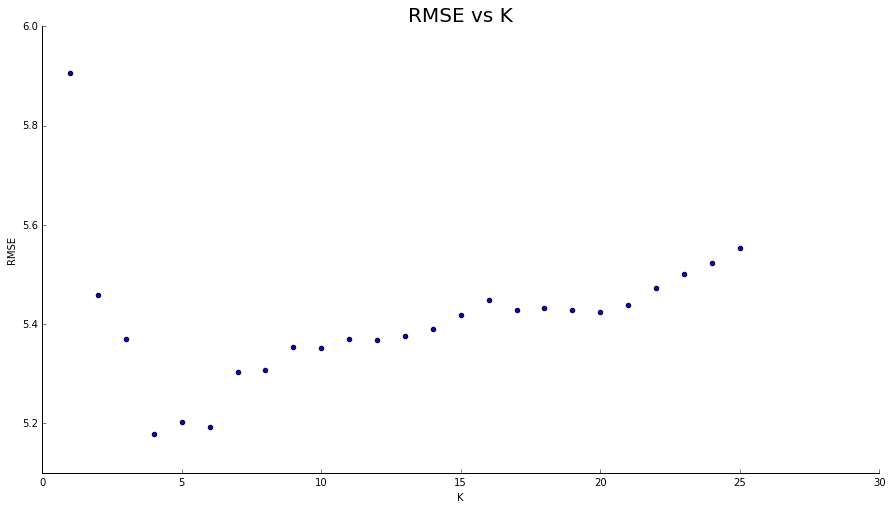

In [15]:
plt.scatter(range(1,26), rmse)

# make the labels and axes
plt.gcf().set_size_inches(15,8)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.xlim(0)
plt.title('RMSE vs K', fontsize=20)

# get rid of lines we don't want
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', top='off')     
plt.tick_params(axis='y', right='off')

plt.show()

RMSE dips down at K = 4~6 and as such I would pick a K value around there.

It probably goes up after ~7 because it is taking into account neighbors that aren't really that close anymore and are thus skewing the prediction away from the actual value. When we have a very low K we are overfitting, assuming our traiing set is more accurate than it really is therefore not averaging over enough neighbors, and thus getting worse results.

As a note: I used the entire dataset without setting aside a validation set for cross validation. KNN does not do "training" per se and our RMSE is just the average RMSE over the 10 folds (with no check on a validation set) so I figured more data was better and used all of it in the 10 folds.
If you want to use just the training set under the 2.5 section at the top change boston.copy() to bdata_train.copy()

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*